In [77]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

In [78]:
# 1. Load and preprocess the Metro Interstate Traffic Volume dataset
def load_and_preprocess_data():
    data = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
    
    # Handle missing values
    data['holiday'] = data['holiday'].fillna('None')
    data = data.dropna()
    
    # Convert date_time to datetime and extract features
    data['date_time'] = pd.to_datetime(data['date_time'], errors='coerce')
    data['hour'] = data['date_time'].dt.hour
    data['day_of_week'] = data['date_time'].dt.dayofweek
    data['month'] = data['date_time'].dt.month
    data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)
    
    # Encode categorical variables
    le_holiday = LabelEncoder()
    le_weather_main = LabelEncoder()
    le_weather_desc = LabelEncoder()
    data['holiday_encoded'] = le_holiday.fit_transform(data['holiday'])
    data['weather_main_encoded'] = le_weather_main.fit_transform(data['weather_main'])
    data['weather_desc_encoded'] = le_weather_desc.fit_transform(data['weather_description'])
    
    # Add synthetic signal timing (as it's not in the dataset)
    data['signal_timing'] = np.random.uniform(30, 120, len(data))
    
    # Create interaction features
    data['temp_rain_interaction'] = data['temp'] * data['rain_1h']
    data['temp_clouds_interaction'] = data['temp'] * data['clouds_all']
    data['rain_snow_interaction'] = data['rain_1h'] * data['snow_1h']
    
    # Select features and target
    features = ['hour', 'day_of_week', 'month', 'is_weekend', 'holiday_encoded', 
                'weather_main_encoded', 'weather_desc_encoded', 'temp', 'rain_1h', 
                'snow_1h', 'clouds_all', 'signal_timing', 'temp_rain_interaction', 
                'temp_clouds_interaction', 'rain_snow_interaction']
    X = data[features]
    y = data['traffic_volume']
    
    return X, y, data

In [79]:
# 2. Prepare data for modeling
X, y, data = load_and_preprocess_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
# 3. Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate model
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.2f}')

Mean Squared Error: 206455.48
R² Score: 0.95


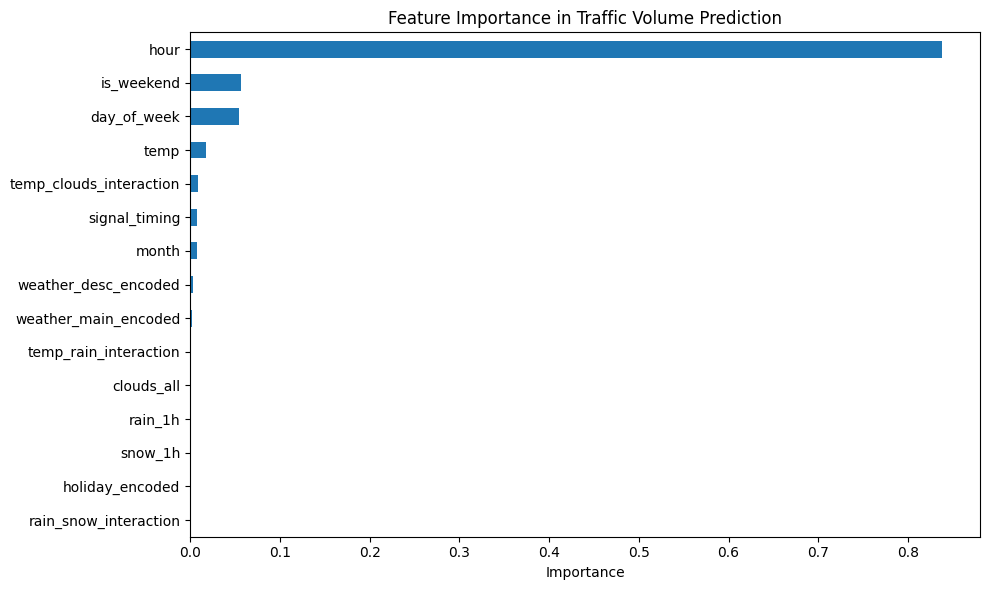

In [81]:
# 4. Visualize feature importance
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
feature_importance.sort_values().plot(kind='barh')
plt.title('Feature Importance in Traffic Volume Prediction')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()
plt.close()

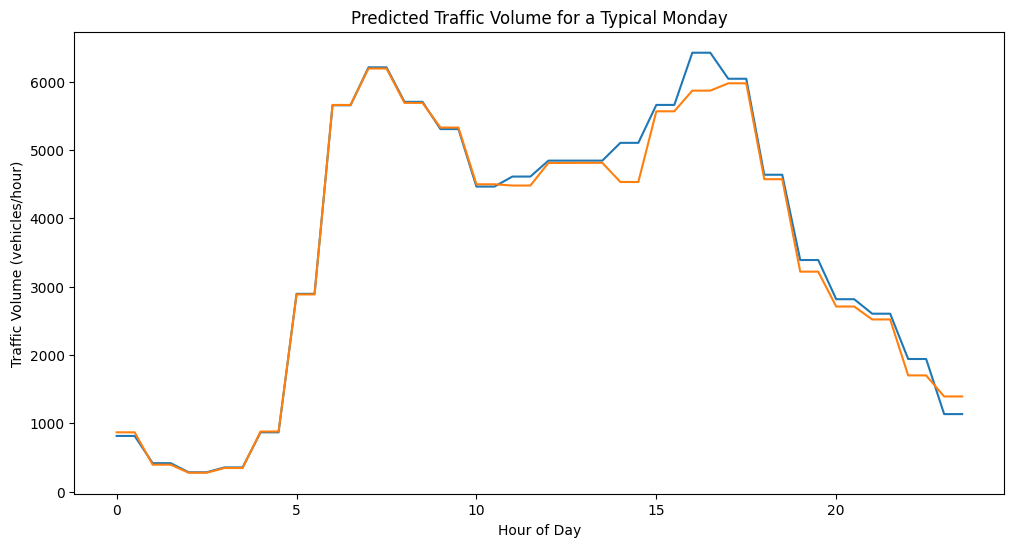

In [82]:
# 5. Predict traffic volume for a typical weekday with varying weather
sample_data = pd.DataFrame({
    'hour': np.arange(0, 24, 0.5),
    'day_of_week': [1] * 48,  # Monday
    'month': [10] * 48,  # October
    'is_weekend': [0] * 48,
    'holiday_encoded': [0] * 48,  # None
    'weather_main_encoded': [0] * 48,  # Clear
    'weather_desc_encoded': [0] * 48,  # sky is clear
    'temp': [285.0] * 48,  # Average temperature
    'rain_1h': [0.0] * 48,
    'snow_1h': [0.0] * 48,
    'clouds_all': [20] * 48,
    'signal_timing': [60] * 48,  # Standard 60-second cycle
    'temp_rain_interaction': [0.0] * 48,
    'temp_clouds_interaction': [285.0 * 20] * 48,
    'rain_snow_interaction': [0.0] * 48
})
sample_pred_clear = rf_model.predict(sample_data)

# Sample with rainy conditions
sample_data_rain = sample_data.copy()
sample_data_rain['weather_main_encoded'] = [9] * 48  # Rain
sample_data_rain['weather_desc_encoded'] = [10] * 48  # light rain
sample_data_rain['rain_1h'] = [1.0] * 48
sample_data_rain['temp_rain_interaction'] = [285.0 * 1.0] * 48
sample_pred_rain = rf_model.predict(sample_data_rain)

# Visualize predicted traffic volume
plt.figure(figsize=(12, 6))
plt.plot(sample_data['hour'], sample_pred_clear, label='Clear Weather')
plt.plot(sample_data_rain['hour'], sample_pred_rain, label='Rainy Weather')
plt.xlabel('Hour of Day')
plt.ylabel('Traffic Volume (vehicles/hour)')
plt.title('Predicted Traffic Volume for a Typical Monday')
plt.show()
plt.close()
plt.close()

Optimal signal timing at 8 AM (Clear): 114.94 seconds
Optimal signal timing at 8 AM (Rainy): 81.57 seconds


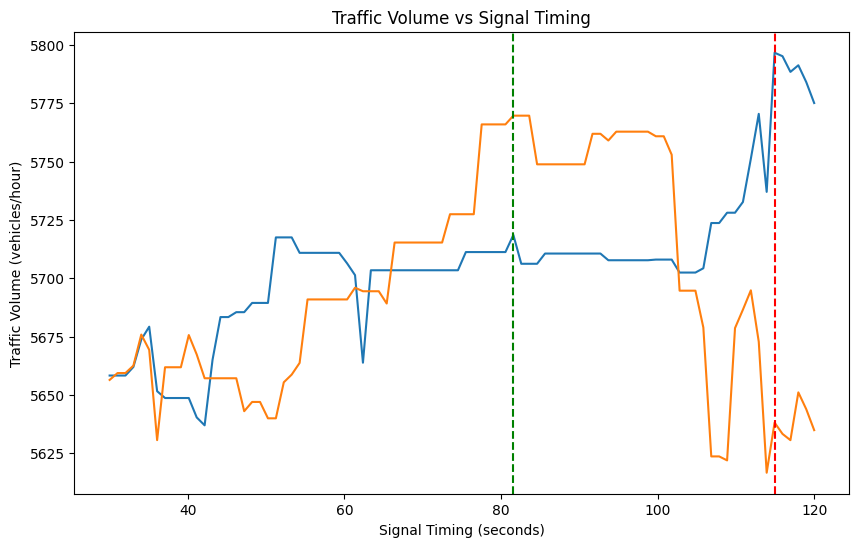

In [83]:
# 6. Optimize signal timing for peak hour (8 AM) under different weather conditions
def optimize_signal_timing(hour=8.0, weather_main=0, weather_desc=0, rain_1h=0.0):
    timing_range = np.linspace(30, 120, 90)
    peak_hour_data = pd.DataFrame({
        'hour': [hour] * 90,
        'day_of_week': [1] * 90,  # Monday
        'month': [10] * 90,
        'is_weekend': [0] * 90,
        'holiday_encoded': [0] * 90,
        'weather_main_encoded': [weather_main] * 90,
        'weather_desc_encoded': [weather_desc] * 90,
        'temp': [285.0] * 90,
        'rain_1h': [rain_1h] * 90,
        'snow_1h': [0.0] * 90,
        'clouds_all': [20] * 90,
        'signal_timing': timing_range,
        'temp_rain_interaction': [285.0 * rain_1h] * 90,
        'temp_clouds_interaction': [285.0 * 20] * 90,
        'rain_snow_interaction': [rain_1h * 0.0] * 90
    })
    peak_pred = rf_model.predict(peak_hour_data)
    optimal_timing = timing_range[np.argmax(peak_pred)]
    return optimal_timing, peak_pred, timing_range

# Optimize for clear and rainy conditions
optimal_timing_clear, peak_pred_clear, timing_range = optimize_signal_timing(weather_main=0, weather_desc=0, rain_1h=0.0)
optimal_timing_rain, peak_pred_rain, timing_range = optimize_signal_timing(weather_main=9, weather_desc=10, rain_1h=1.0)
print(f'Optimal signal timing at 8 AM (Clear): {optimal_timing_clear:.2f} seconds')
print(f'Optimal signal timing at 8 AM (Rainy): {optimal_timing_rain:.2f} seconds')

# Visualize signal timing optimization
plt.figure(figsize=(10, 6))
plt.plot(timing_range, peak_pred_clear, label='Clear Weather')
plt.plot(timing_range, peak_pred_rain, label='Rainy Weather')
plt.axvline(x=optimal_timing_clear, color='r', linestyle='--', label=f'Clear Optimal: {optimal_timing_clear:.2f}s')
plt.axvline(x=optimal_timing_rain, color='g', linestyle='--', label=f'Rain Optimal: {optimal_timing_rain:.2f}s')
plt.xlabel('Signal Timing (seconds)')
plt.ylabel('Traffic Volume (vehicles/hour)')
plt.title('Traffic Volume vs Signal Timing')
plt.show()
plt.close()

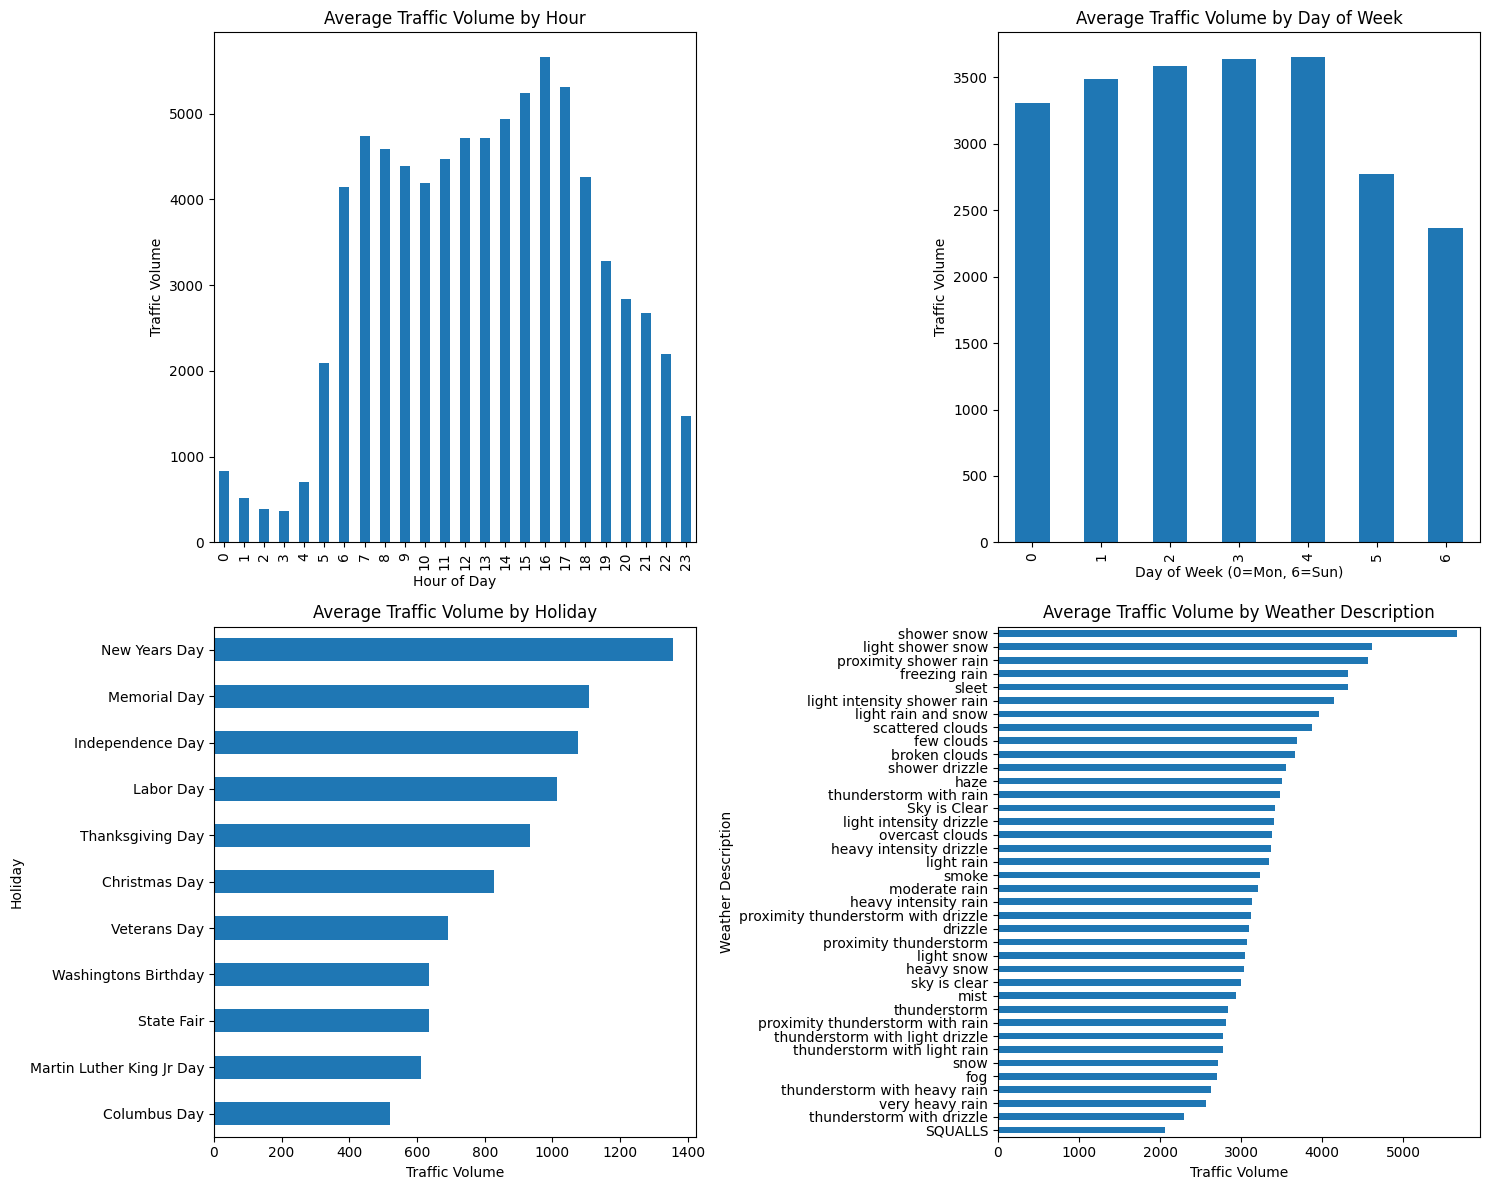

In [84]:
# 7. Visualize traffic volume by hour, day of week, holiday, and weather description
plt.figure(figsize=(15, 12))

# Hourly traffic volume
plt.subplot(2, 2, 1)
hourly_avg = data.groupby('hour')['traffic_volume'].mean()
hourly_avg.plot(kind='bar')
plt.title('Average Traffic Volume by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Traffic Volume')

# Daily traffic volume
plt.subplot(2, 2, 2)
daily_avg = data.groupby('day_of_week')['traffic_volume'].mean()
daily_avg.plot(kind='bar')
plt.title('Average Traffic Volume by Day of Week')
plt.xlabel('Day of Week (0=Mon, 6=Sun)')
plt.ylabel('Traffic Volume')

# Traffic volume by holiday
plt.subplot(2, 2, 3)
holiday_avg = data[data['holiday'] != 'None'].groupby('holiday')['traffic_volume'].mean().sort_values()
holiday_avg.plot(kind='barh')
plt.title('Average Traffic Volume by Holiday')
plt.xlabel('Traffic Volume')
plt.ylabel('Holiday')

# Traffic volume by weather description
plt.subplot(2, 2, 4)
weather_desc_avg = data.groupby('weather_description')['traffic_volume'].mean().sort_values()
weather_desc_avg.plot(kind='barh')
plt.title('Average Traffic Volume by Weather Description')
plt.xlabel('Traffic Volume')
plt.ylabel('Weather Description')

plt.tight_layout()
plt.show()
plt.close()

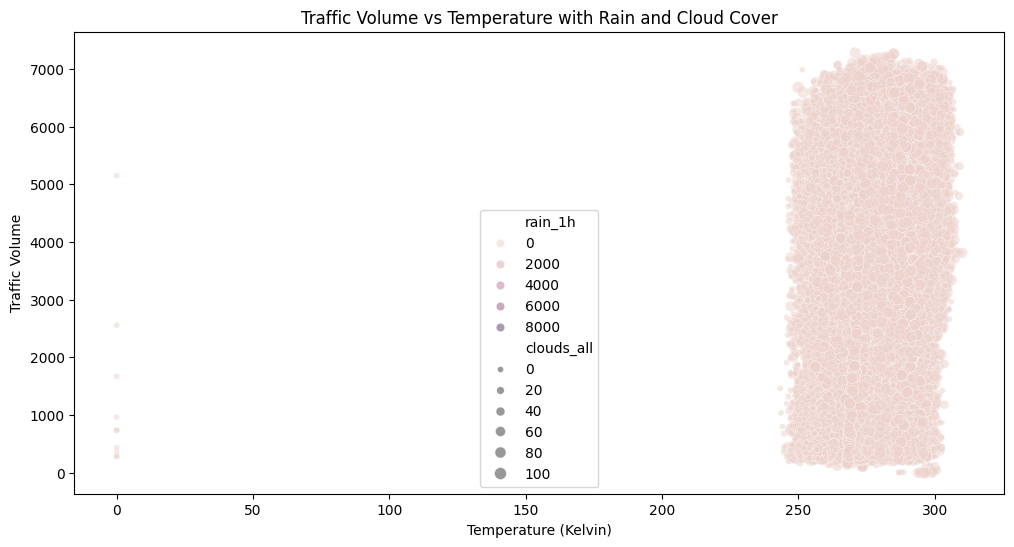

In [85]:
# 8. Visualize weather impacts on traffic volume
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='temp', y='traffic_volume', hue='rain_1h', size='clouds_all', alpha=0.5)
plt.title('Traffic Volume vs Temperature with Rain and Cloud Cover')
plt.xlabel('Temperature (Kelvin)')
plt.ylabel('Traffic Volume')
plt.show()
plt.close()